In [1]:
from pickling import load_pickle, create_pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import researchpy as rp
import statsmodels.api as sm
import choplo_statistique as cstats
import choplo_visualization as cvis
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import statsmodels as sm
import os

In [2]:
a_df = load_pickle('amp')
a_side_df = load_pickle('side_amp')
a_jt_df = load_pickle('amp_jt_new_filt')
a_jt_full_df = load_pickle('amp_not_norm_joint_df_new_filt')
a_angle_full_df = load_pickle('amp_not_norm_angle_df_new_filt')
a_st_df = load_pickle('amp_strat_new_filt')
a_missing_df = load_pickle('missing_amp')

v_df = load_pickle('vit')
v_side_df = load_pickle('side_vit')
v_jt_df = load_pickle('vit_jt_new_filt')
v_st_df = load_pickle('vit_strat_new_filt')
v_jt_full_df = load_pickle('vit_not_norm_joint_df_new_filt')
v_angle_full_df = load_pickle('vit_not_norm_angle_df_new_filt')
v_missing_df = load_pickle('missing_vit') 

idx = pd.IndexSlice

C:\Users\tousi\AppData\Local\conda\conda\envs\python37\lib\site-packages\pandas\core\indexes\base.py:162: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [3]:
def convert_index_to_range_int(df):
    from copy import deepcopy
    idx0_name, idx1_name, idx2_name = 'lvl', 'players', 'moves'
    n0, n1, n2 = df.index.get_level_values(0).unique().size, df.index.get_level_values(1).unique().size, df.index.get_level_values(2).unique().size
    arr0 = list(range(n0))
    arr1 = list(range(n1))
    arr2 = list(range(n2))
    new_index = pd.MultiIndex.from_product([arr0,arr1, arr2])
    new_index.set_names([idx0_name, idx1_name, idx2_name], inplace=True)
    df_copy = deepcopy(df)
    df_copy.index = new_index
    return df_copy

def find_index(df, lvl, p):
    idx = pd.IndexSlice
    return df.loc[idx[lvl, p, :]].index.get_level_values(2)

def split_df_by_moves_slices(df, num_moves=30, size_slice=10):
    df_sliced=[]
    idx = pd.IndexSlice
    try:
        if num_moves/size_slice % 1 != 0:
            raise ValueError("size_slice must be multiple of num_moves") 
        num_df = int(num_moves/size_slice)
    except ValueError as e:
        print(e)
        print("split_df_by_moves_slices Cancelled : change num_moves or size_slice")
        return None
    
    n_lvl0 = df.index.get_level_values(0).unique().size
    n_lvl1 = df.index.get_level_values(1).unique().size
    
    for i in range(0,num_df):
        new_df = None
        for l in range(0,n_lvl0):
            for p in range(0, n_lvl1):
                try:
                    if i == num_df-1:
                        move_index = find_index(df, l,p)
                        start = move_index[-size_slice]
                        end = None
                    else:
                        move_index = find_index(df, l,p)
                        start = move_index[i * size_slice]
                        end = move_index[(i+1) * size_slice -1]
                except Exception:
                    move_index = find_index(df, l,p)
                    start = move_index[-size_slice]
                    end = None
#                     print("EXCEPTION")

                finally:
                    if new_df is None:
                        new_df = df.loc[idx[l,p,start:end]]
                    else:
                        new_df = pd.concat([new_df, df.loc[idx[l,p,start:end]]])
        df_sliced.append(new_df)
    return df_sliced
                    
def select_sliced_df_from_one_var(df_sliced, col_name):
    """Index doit etre lvl, player, moves, variable hue. Colonne = slice1, slice2, slice3,..."""
    temp_list = []
    for df in df_sliced:
        temp = pd.concat([df.loc[0].groupby(level=0).mean(), df.loc[1].groupby(level=0).mean(), df.loc[2].groupby(level=0).mean()],keys=[0,1,2])
        temp_list.append(temp)

    n_slice = len(df_sliced)
    col_names = list('Section - {}'.format(i) for i in range(0,n_slice))
    df = pd.concat(temp_list, axis =1, keys=col_names)
    return df

def get_grid_learning_compare_to_section_test(dfs, lvl=0, nplayers=10, section_to_compare_id=0):
    """returns a grid of corrected pvalues"""
    pvals_uncorrect = []
    for p in range(0, nplayers):
        data_ref = dfs[section_to_compare_id].loc[lvl].loc[p]
        pvals_uncorrect.append(1) #first col of grid can't have value assess 1
        for s in range(1, len(dfs)):
            data1 = data_ref
            data2 = dfs[s].loc[lvl].loc[p]
            var_test = stats.levene(data1, data2)
            var_test = var_test[1] > 0.05 #
            try:
                skew1 = stats.skewtest(data1)
                skew2 = stats.skewtest(data2)
            except Exception:
                skew1 = False
                skew2 = False
            
            if var_test and skew1 and skew2:
                #condition for independant t-test respected
                res = stats.ttest_ind(data1, data2) #stats, pval
            else:
                print("wilcoxon for level: ", lvl," - player: ", p, ' - section: ', s)
                res = stats.wilcoxon(data1, data2) #condition not respected for ttest ind, perform wilcoxon
                
            pvals_uncorrect.append(res[1])
    
    
    #multitest correction
    pvals_uncorrect = np.array(pvals_uncorrect)
    pvals_corrected = sm.stats.multitest.multipletests(pvals_uncorrect, method='fdr_bh')
    
    #reshape to grid
    pvals_uncorrect = pvals_uncorrect.reshape(nplayers, len(dfs))
    pvals_corrected = pvals_uncorrect.reshape(nplayers, len(dfs))
    
    
    return pvals_uncorrect,  pvals_corrected

def get_grid_learning_sequential_test(dfs, lvl=0, nplayers=10):
    """returns a grid of corrected pvalues"""
    pvals_uncorrect = []
    for p in range(0, nplayers):
#         data_ini = dfs[0].loc[0].loc[p]
        pvals_uncorrect.append(1) #first col of grid can't have value assess 1
        for s in range(1, len(dfs)):
            data1 = dfs[s-1].loc[lvl].loc[p]
            data2 = dfs[s].loc[lvl].loc[p]
            var_test = stats.levene(data1, data2)
            var_test = var_test[1] > 0.05 #
            try:
                skew1 = stats.skewtest(data1)
                skew2 = stats.skewtest(data2)
            except Exception:
                skew1 = False
                skew2 = False
            
            if var_test and skew1 and skew2:
                #condition for independant t-test respected
                res = stats.ttest_ind(data1, data2) #stats, pval
            else:
                print("wilcoxon for level: ", lvl," - player: ", p, ' - section: ', s)
                res = stats.wilcoxon(data1, data2) #condition not respected for ttest ind, perform wilcoxon
                
            pvals_uncorrect.append(res[1])
    
    
    #multitest correction
    pvals_uncorrect = np.array(pvals_uncorrect)
    pvals_corrected = sm.stats.multitest.multipletests(pvals_uncorrect, method='fdr_bh')
    
    #reshape to grid
    pvals_uncorrect = pvals_uncorrect.reshape(nplayers, len(dfs))
    pvals_corrected = pvals_uncorrect.reshape(nplayers, len(dfs))
    
    
    return pvals_uncorrect,  pvals_corrected

def heatmap_label(pval_df, ncols, existing_grid=None, force_symbol = None):
    from copy import deepcopy
    def modify_label(s):
        s = s.replace(' ', '-')
        s.strip('-').replace('--','-')
        return s
    
    if existing_grid is None:
        label_grid=deepcopy(pval_df)
        label_grid[:] = ''
    else:
        label_grid = existing_grid
    for c in range(0, ncols):
        if force_symbol is None:
            label = " {} ".format(c)
        else:
            label = " {} ".format(force_symbol)
        label_grid[c][pval_df[c]<0.05] += label
#     label_grid = label_grid.applymap(modify_label)
    label_grid = label_grid.applymap(remove_duplicate_in_label)
        
    return label_grid


def remove_duplicate_in_label(s):
    s = sorted(s)
    temp = []
    [temp.append(x) for x in s if x not in temp]
    label =' ' + ' '.join(temp[1:]) + ' '
    return label

def create_heat_map_label(dfs, lvls=3, nplayers=10):
    n_dfs = len(dfs)
    label_grid = []    
    ini_pval_grid = [] #pval test compared to initial value
    seq_pval_grid = [] #pval test compared to last section

    for lvl in range(0, lvls):
        _, ini_corr = get_grid_learning_compare_to_section_test(dfs, lvl=lvl, nplayers=nplayers, section_to_compare_id=0)
        _, seq_corr = get_grid_learning_sequential_test(dfs, lvl=lvl, nplayers=nplayers)
        ini_pval_grid.append(pd.DataFrame(ini_corr))
        seq_pval_grid.append(pd.DataFrame(seq_corr))
    
    ini_pval = pd.concat(ini_pval_grid, keys= list(range(lvls))) #concat all level 
    seq_pval = pd.concat(seq_pval_grid, keys= list(range(lvls))) #concat all level
    seq_pval_label = heatmap_label(seq_pval, ncols=len(dfs))
    pval_label = heatmap_label(ini_pval, ncols=len(dfs), existing_grid=seq_pval_label, force_symbol=1)
    
    return pval_label
    

def split_moves_for_one_var(df, size_slice, var, hue):
    df = convert_index_to_range_int(df)
    df.dropna(how='all', inplace=True)
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    df = df.loc[:, idx[var,hue]]
    dfs = split_df_by_moves_slices(df, size_slice=size_slice)
    final_df = select_sliced_df_from_one_var(dfs, var)
    pval_label = create_heat_map_label(dfs, lvls=3, nplayers=10)
    return final_df, dfs, pval_label

In [4]:
def plot3_heatmap(data1= None, data2=None, data3=None, data=None, name1=None, name2=None, name3=None, cmap = "Greys_r",label_annot=None, save=False, size_slice=10, cb_label='_', num_goutte=30, condition="_", hue='_', var="_"):
    import matplotlib
    from matplotlib.ticker import FormatStrFormatter

    font = {'weight': 'normal',
        'size'   : 16}

    matplotlib.rc('font', **font)
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
    fig.set_size_inches(18.5, 10)
    m, M = data.min().min(), data.max().max()
    g1 = sns.heatmap(data1, cmap=cmap, vmin=m, vmax=M, annot=label_annot.loc[0].values, fmt='', cbar=False, annot_kws={"size": 20, 'fontweight': 'bold'}, ax=axes[0], linewidths=1.5)
    g2 = sns.heatmap(data2, cmap=cmap, vmin=m, vmax=M, annot=label_annot.loc[1].values, fmt='', cbar=False, annot_kws={"size": 20, 'fontweight': 'bold'}, ax=axes[1], linewidths=1.5)
    g3 = sns.heatmap(data3, cmap=cmap, vmin=m, vmax=M, annot=label_annot.loc[2].values, fmt='', cbar=True,  annot_kws={"size": 20, 'fontweight': 'bold'}, cbar_kws={'label': cb_label}, linewidths=1.5, ax=axes[2])
    
    xticks = xticks_for_learning_heatmap(size, num_goutte)
    for ax in axes:
        ax.set_xticklabels(xticks, rotation=0, fontsize=14)
    
    g1.set_ylabel('Joueur')
    g1.set_yticklabels(list(range(1,11)))
    g1.set_title(name1)
    g2.set_title(name2)
    g2.set_ylabel('')
    g3.set_title(name3)
    g3.set_ylabel('')

    fig.suptitle("Effet de l'apprentissage de la tâche lors de la condition {}".format(condition), fontsize=20)
    
    if save:
        cwd = os.getcwd().replace('\\', '/')
        png_name = cwd + '/output/learning/graph_without_outliar/learning_effet_{}_{}_{}.png'.format(condition, var, hue)
        plt.savefig(png_name, dpi=1000)
        plt.close()

def xticks_for_learning_heatmap(size, num_goutte):
    section = int(num_goutte/size)
    xticks = []
    label = '#{}({}-{})'
    for i in range(0, section):
        lower = 1+(i*size)
        upper = 0+(i+1)*size
        xticks.append(label.format(i+1,lower, upper))
    return xticks
        

wilcoxon for level:  1  - player:  3  - section:  1
wilcoxon for level:  1  - player:  3  - section:  1


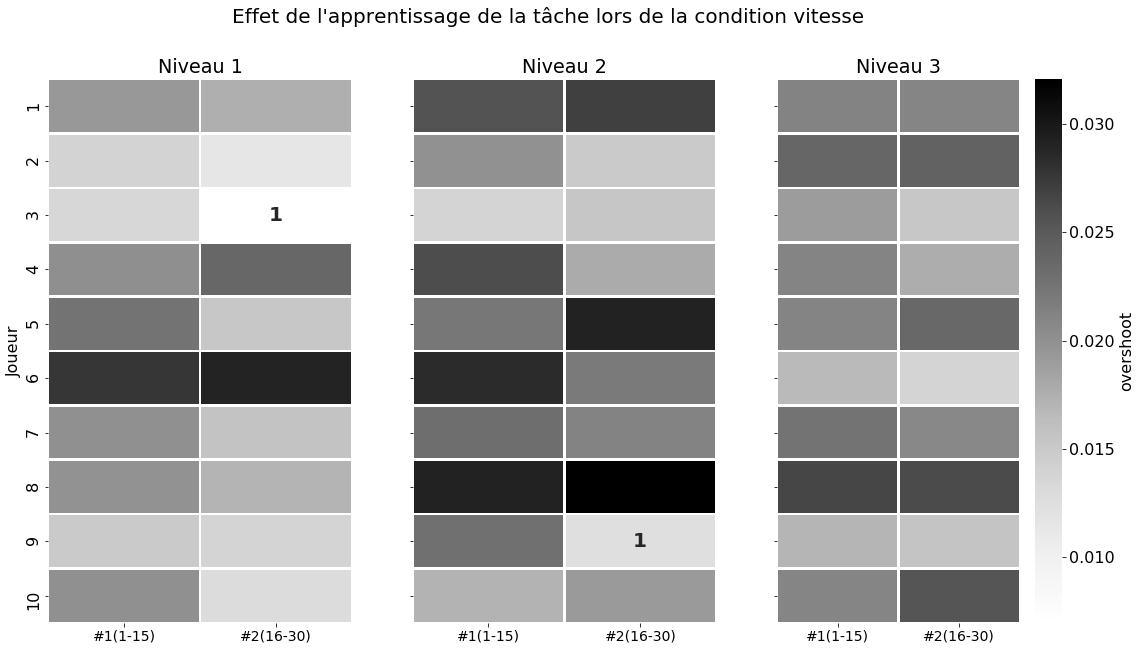

In [5]:
df, var, hue, condition, size, num_goutte = a_df, 'overshoot', 'value', 'vitesse', 15, 30
data, dfs, labels=split_moves_for_one_var(df, size, var, hue)
data1, data2, data3 = data.loc[0], data.loc[1],data.loc[2]
plot3_heatmap(data1, data2, data3, data, 'Niveau 1', 'Niveau 2', 'Niveau 3', cmap='Greys', label_annot=labels, cb_label=var, var=var,save = False, hue=hue, condition=condition)

In [6]:
all_vars = ["start_cm", "rel_pt", "amp_max_cop", 'amp_max_pel', 'amp_max_c7', "vel_max_cop", 'vel_max_pel',
                       'vel_max_c7', "overshoot", "dcm", "dtml", "rcm"]
label_vars= ["t_r (s)", "t_r (m)", "cm_max (s)", "cm_max (m)", "tML_max CdP (s)", "tML_max CdP (m)", 
            "tML_max Sb_k (s)", "tML_max Sb_k (m)", "tML_max Ms_k (s)", "tML_max Ms_k (m)", "V_max CdP (s)", 
            "V_max CdP (m/s)", "V_max Sb_k (s)", "V_max Sb_k (m/s)", "V_max Ms_k (s)", "V_max Ms_k (m/s)", 
           "overshoot (s)", "overshoot (m)", "dcm (s)", "dcm (m)", "dtml (s)", "dtml (m)", "rcm (s)",  "rcm (m)"]

all_hue = ['index', 'value']


In [7]:
def save_all_learning_graph_one_condition(df, condition, size, num_goutte, all_vars, all_hue, label_vars=None):
    i = 0
    for v in all_vars:
        for h in all_hue:
            if label_vars is None:
                v_label = v
            else:
                v_label = label_vars[i]
            data, dfs, labels=split_moves_for_one_var(df, size, v, h)
            data1, data2, data3 = data.loc[0], data.loc[1],data.loc[2]
            plot3_heatmap(data1, data2, data3, data, 'Niveau 1', 'Niveau 2', 'Niveau 3', cmap='Greys', label_annot=labels, cb_label=v_label, var=v,save = True, hue=h, condition=condition)
            i+=1

In [ ]:
save_all_learning_graph_one_condition(a_df, 'amplitude', 15, 30, all_vars, all_hue, label_vars)

wilcoxon for level:  0  - player:  8  - section:  1
wilcoxon for level:  0  - player:  8  - section:  1
wilcoxon for level:  2  - player:  2  - section:  1
wilcoxon for level:  2  - player:  2  - section:  1
wilcoxon for level:  1  - player:  6  - section:  1
wilcoxon for level:  1  - player:  6  - section:  1
wilcoxon for level:  2  - player:  9  - section:  1
wilcoxon for level:  2  - player:  9  - section:  1
wilcoxon for level:  1  - player:  5  - section:  1
wilcoxon for level:  1  - player:  5  - section:  1
wilcoxon for level:  2  - player:  9  - section:  1
wilcoxon for level:  2  - player:  9  - section:  1


In [ ]:
save_all_learning_graph_one_condition(v_df, 'vitesse', 15, 30, all_vars, all_hue, label_vars)

In [ ]:
a_f